# Guide to notebook
A small guide of what is contained in the notebook
* **Load data from raw** - Loads the relevant tables from the dataset to look at them
* **Data Processing** - data is processed by trandforming it to long format and doing some additional formatting

## Load Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats

## Load data from raw

In [2]:
#marriage_by_year = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="1a", header =6)

#looks at the sex and legal status
op_sex_status = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="3a", header =6)
same_sex_status = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="3b", header =5)

#looks at the sex and age
op_sex_age = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="4a", header =6)
same_sex_age = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="4b", header =5)

#the proportions of marriages based on sex and age
op_sex_prop = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="5a", header =8)
same_sex_prop = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="5b", header =9)

#the median age of marriage over the years
op_med_age = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="6a", header =6)
same_med_age = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="6b", header =5)

#the mean age of marriage over the years
op_mean_age =pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="7a", header =6)
same_mean_age = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="7b", header =5)

#op_time = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="9a", header =5)
#same_time = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="9b", header =6)

#looking at the percentage of marriages that had cohabitation before hand
op_cohabit = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="11a", header =5)
same_cohabit = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="11b", header =5)

#Looking at same sex marriages that converted from civil partnership to marriage
same_conv = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="13", header =8)

#porportions married by a certain age
men_age = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="14a", header =5)
women_age = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="14b", header =5)

#proportoins of remmarried by a certian age
men_age_prop = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="15a", header =5)
women_age_prop = pd.read_excel("marriagesworkbook2020.xlsx", sheet_name ="15b", header =5)

# Data Preprocessing
In this section we introduce some functions that transforms the data to long format and adds some filters to remove outliers or irrelevant data. We also replace not applicable values with nan values then add the sex of where the data is from. Then we check if there are any duplicates in the data to make sure no duplicates are present

In [3]:
def transform(df, opp, id_vars):
    #transfroms data from wide to long
    df =pd.melt(df, id_vars=id_vars, )

    #splits the sex and age to 2 different columns
    df[["Sex", "Age"]] = df["variable"].str.split('\n',expand=True)

    #drops the variable column
    df= df.drop(["variable"], axis =1)

    #removes the total from the age and status
    df= df[df["Age"]!="Total"]

    #removes the Age not stated as it does not give extra info
    df= df[df["Age"]!="Age not stated"]
    
    #replace not available with a nan
    df.loc[df["value"]=="[z]", "value"]=np.nan
    df.loc[df["value"]=="[x]", "value"]=np.nan
    
    #filters to remove 2020 due to covid 19
    df = df[df["Year"]!=2020]
    
    df["marriage sex"]= opp
    
    return(df)
    

In [4]:
def transform_3(df, opp):
    #transfroms data from wide to long
    df = transform(df, opp, id_vars=["Year", "Legal partnership status"])
    
    #removes the total status
    df= df[df["Legal partnership status"]!="Total"]
    df= df[df["Legal partnership status"]!="Not Stated"]

    return(df)
    

In [5]:
def transform_4(df, opp):
     #transfroms data from wide to long
    df =transform(df, opp, id_vars=["Year"])
    
    #removes this category as its nearly accumulates all the ages
    df = df.loc[df["Age"]!="Ages 16 and over",:]
    
    return(df)

In [6]:
def transform_sex(df, cols,extra_cols, neutral_cols, sex):
    #gets the data from a particular sex and then makes the colnames to a neutral name
    
    #selects the particlar columns
    df_sex = df.loc[:,extra_cols+cols]
    
    #sets the sex as the chosen sex
    df_sex["sex"] = sex
    
    #renames the names to have a neutral name
    df_sex = df_sex.rename({cols[i]:neutral_cols[i] for i in range(len(neutral_cols))}, axis=1)
    
    return(df_sex)

def transform_med(df):
    #transfomrs the median or mean data by splitting the data for sex and  combines it to long format
    
    #sets the neutral column names that are that sex specific
    neutral_cols = ["All", "All never married", "All widows/widower", "All divorced"]
    extra_cols =["Year", "marriage sex"]
    
    #gets the specifc column names for mean and women
    men_cols = list(df.columns[[sum([t in i for t in [" men", "widowers"]])==1 for i in df.columns]])
    women_cols = list(df.columns[[sum([t in i for t in [" women", "widows"]])==1 for i in df.columns]])
    
    #gets the long data with the a sex column
    men_med = transform_sex(df, men_cols, extra_cols, neutral_cols, "men")
    women_med = transform_sex(df, women_cols, extra_cols,  neutral_cols, "women")

    #combines the data and replaced the non applicable data to nan
    med_df = pd.concat([men_med, women_med])
    med_df = med_df.replace("[x]", np.nan)
    
    #filters to remove 2020 due to covid 19
    med_df = med_df[med_df["Year"]!=2020]
    
    #resets the index
    med_df = med_df.reset_index(drop=True)
    
    return(med_df)

In [7]:
def transform_cohabit(df, op):
    #transforms the cohabitaion data by turning the data long data
    
    #changes the neutral cols due to same sex marriages have not got a religous category
    if op:
        neutral_cols = ["%All", "%Civil Marriages", "%Religous"]
    else:
        neutral_cols = ["%All", "%Civil Marriages"]
        
    extra_cols =["Year", "marriage sex", "Age"]
    
    #find the columns for mean and women
    men_cols = list(df.columns[[sum([t in i for t in [" men"]])==1 for i in df.columns]])
    women_cols = list(df.columns[[sum([t in i for t in [" women"]])==1 for i in df.columns]])
    
    #splits the data into mena and women and combines the data
    men_cohabit = transform_sex(df, men_cols, extra_cols, neutral_cols, "men")
    women_cohabit = transform_sex(df, women_cols, extra_cols, neutral_cols, "women")

    #combines the data and replace the non applicable data to nan
    cohabit_df = pd.concat([men_cohabit, women_cohabit])
    cohabit_df =cohabit_df.replace("[x]", np.nan)
    
    #filters to remove 2020 due to covid 19
    cohabit_df = cohabit_df[cohabit_df["Year"]!=2020]
    
    #resets the index
    cohabit_df = cohabit_df.reset_index(drop=True)
    
    return(cohabit_df)

In [8]:
def has_duplicates(df):
    #checks if the data has duplicates or not
    
    if sum(df.duplicated())>0:
        print("data has "+ str(sum(df.duplicated())) + " duplicates")
    else:
        print("data has no duplicates")
    

In [9]:
#transforming the data
trans_op_sex_status = transform_3(op_sex_status, "opposite")
trans_same_sex_status = transform_3(same_sex_status, "same")

#concat the dataa into one table
sex_status = pd.concat([trans_op_sex_status, trans_same_sex_status ])
sex_status = sex_status.reset_index(drop = True)

In [10]:
##For the number of marriages
#transform the data
trans_op_sex_age = transform_4(op_sex_age, "opposite")
trans_same_sex_age = transform_4(same_sex_age, "same")

#concat the dataa into one table
sex_age = pd.concat([trans_op_sex_age, trans_same_sex_age])
sex_age = sex_age.reset_index(drop=True)

In [11]:
## For proportions
#transform the data
trans_op_sex_prop = transform_4(op_sex_prop, "opposite")

#remove relative columns
trans_same_sex_prop = same_sex_prop.loc[:,["Rel" not in i for i in same_sex_prop.columns]]

trans_same_sex_prop = transform_4(trans_same_sex_prop, "same")

#removes the low data as nan data
trans_same_sex_prop.loc[trans_same_sex_prop["value"]=="[low]", "value"]=np.nan


sex_prop = pd.concat([trans_op_sex_prop, trans_same_sex_prop])
sex_prop = sex_prop.reset_index(drop=True)

In [12]:
## For median age
op_med_age["marriage sex"] = "opposite"
same_med_age["marriage sex"] = "same"

op_med = transform_med(op_med_age)
same_med = transform_med(same_med_age)

med_age = pd.concat([op_med, same_med])
med_age= med_age.reset_index(drop=True)

In [13]:
##For the mean age

#Removes the annoying \n
op_mean_age.columns = [i.replace("\n", " ") for i in op_mean_age.columns]
same_mean_age.columns = [i.replace("\n", " ") for i in same_mean_age.columns]

op_mean_age_all = op_mean_age.loc[:,["Year", "All men","All never married men", "All widowers", "All divorced men",
                                     "All women","All never married women", "All widows", "All divorced women"]]
same_mean_age_all = op_mean_age.loc[:,["Year", "All men","All never married men", "All widowers", "All divorced men",
                                       "All women","All never married women", "All widows", "All divorced women"]]

op_mean_age_all["marriage sex"] = "opposite"
same_mean_age_all["marriage sex"] = "same"

op_mean_full = transform_med(op_mean_age_all)
same_mean_full = transform_med(same_mean_age_all)

mean_age_full = pd.concat([op_mean_full, same_mean_full])
mean_age_full = mean_age_full.reset_index(drop=True)

In [14]:
##For % of cohabitation to marriage
op_cohabit["marriage sex"] = "opposite"
same_cohabit["marriage sex"] = "same"

op_co = transform_cohabit(op_cohabit, True) 
same_co = transform_cohabit(same_cohabit, False) 

co_df = pd.concat([op_co, same_co])

In [15]:
## For conversion from civil partnership to marriages for same sex couples
same_conv_df = same_conv.drop(["Number of male conversions", "Number of female conversions", "All conversions"],axis=1)
conv_df = transform(same_conv_df, "same", id_vars=["Year"])

In [16]:
## For age in years of people getting married
men_age.columns = [i.replace("\n(years)\n", " ")for i in men_age.columns]
women_age.columns = [i.replace("\n(years)\n", " ")for i in women_age.columns]

men_age_prop = [i.replace("\n(years)\n", " ")for i in men_age_prop.columns]
women_age_prop = [i.replace("\n(years)\n", " ")for i in women_age_prop.columns]

In [17]:
#checks if the data has any duplicates
long_data = [sex_status, sex_age, sex_prop, med_age, mean_age_full, co_df, conv_df]
[has_duplicates(i) for i in long_data]

data has no duplicates
data has no duplicates
data has no duplicates
data has no duplicates
data has no duplicates
data has no duplicates
data has no duplicates


[None, None, None, None, None, None, None]

In [18]:
sex_status.head()

Year Legal partnership status value  Sex       Age marriage sex
0  2019            Never married     0  Men  Under 16     opposite
1  2019                  Widowed     0  Men  Under 16     opposite
2  2019                 Divorced     0  Men  Under 16     opposite
3  2018            Never married     0  Men  Under 16     opposite
4  2018                  Widowed     0  Men  Under 16     opposite

In [19]:
sex_age.head()

Year value  Sex       Age marriage sex
0  2019   422  Men  Under 20     opposite
1  2018   414  Men  Under 20     opposite
2  2017   430  Men  Under 20     opposite
3  2016   523  Men  Under 20     opposite
4  2015   512  Men  Under 20     opposite

In [20]:
sex_prop.head()

Year value  Sex       Age marriage sex
0  2019   0.3  Men  Under 20     opposite
1  2018   0.3  Men  Under 20     opposite
2  2017   0.3  Men  Under 20     opposite
3  2016   0.4  Men  Under 20     opposite
4  2015   0.4  Men  Under 20     opposite

In [21]:
med_age.head()

Year marriage sex   All  All never married  All widows/widower  \
0  2019     opposite  34.3               31.9                66.5   
1  2018     opposite  34.0               32.0                66.0   
2  2017     opposite  34.2               31.8                65.1   
3  2016     opposite  34.1               31.6                65.3   
4  2015     opposite  33.9               31.5                64.5   

   All divorced  sex  
0          51.4  men  
1          51.0  men  
2          50.5  men  
3          50.0  men  
4          49.2  men

In [22]:
mean_age_full.head()

Year marriage sex   All  All never married  All widows/widower  \
0  2019     opposite  38.4               33.9                65.5   
1  2018     opposite  38.1               33.7                64.6   
2  2017     opposite  38.0               33.6                64.5   
3  2016     opposite  37.9               33.4                64.3   
4  2015     opposite  37.5               33.2                63.6   

   All divorced  sex  
0          51.6  men  
1          51.2  men  
2          50.7  men  
3          50.4  men  
4          49.6  men

In [23]:
co_df.head()

Year marriage sex             Age  %All  %Civil Marriages  %Religous  sex
0  2019     opposite  All ages        88.8              90.6       80.1  men
1  2019     opposite        Under 20  49.8              60.1       32.0  men
2  2019     opposite        20 to 24  72.2              80.1       48.2  men
3  2019     opposite        25 to 29  86.6              88.7       79.1  men
4  2019     opposite        30 to 34  90.7              92.0       85.3  men

In [24]:
conv_df.head()

Year   value    Sex               Age marriage sex
1  2019   662.0  Males  Ages 16 and over         same
2  2018   920.0  Males  Ages 16 and over         same
3  2017  1214.0  Males  Ages 16 and over         same
4  2016  1768.0  Males  Ages 16 and over         same
5  2015  8820.0  Males  Ages 16 and over         same

In [25]:
men_age

Year of birth  Exact age 17  Exact age 18  Exact age 19  Exact age 20  \
0             1900             0           1.0           8.0          24.0   
1             1901             0           2.0           8.0          25.0   
2             1902             0           1.0           6.0          19.0   
3             1903             0           1.0           5.0          16.0   
4             1904             0           1.0           4.0          14.0   
..             ...           ...           ...           ...           ...   
100           2000             0           0.0           0.0           1.0   
101           2001             0           0.0           0.0           1.0   
102           2002             0           0.0           0.0           NaN   
103           2003             0           0.0           NaN           NaN   
104           2004             0           NaN           NaN           NaN   

     Exact age 21  Exact age 22  Exact age 23  Exact age 24  Exact age 25  \
0            61.0         135.0         214.0         302.0         396.0   
1            57.0         119.0         191.0         276.0         365.0   
2            44.0         101.0         169.0         248.0         330.0   
3            38.0          92.0         158.0         231.0         319.0   
4            36.0          89.0         151.0         232.0         319.0   
..            ...           ...           ...           ...           ...   
100           2.0           NaN           NaN           NaN           NaN   
101           NaN           NaN           NaN           NaN           NaN   
102           NaN           NaN           NaN           NaN           NaN   
103           NaN           NaN           NaN           NaN           NaN   
104           NaN           NaN           NaN           NaN           NaN   

     ...  Exact age 41  Exact age 42  Exact age 43  Exact age 44  \
0    ...         902.0         907.0         911.0         915.0   
1    ...         883.0         888.0         892.0         895.0   
2    ...         882.0         886.0         891.0         895.0   
3    ...         878.0         882.0         887.0         892.0   
4    ...         885.0         890.0         895.0         900.0   
..   ...           ...           ...           ...           ...   
100  ...           NaN           NaN           NaN           NaN   
101  ...           NaN           NaN           NaN           NaN   
102  ...           NaN           NaN           NaN           NaN   
103  ...           NaN           NaN           NaN           NaN   
104  ...           NaN           NaN           NaN           NaN   

     Exact age 45  Exact age 46  Exact age 47  Exact age 48  Exact age 49  \
0           918.0         921.0         923.0         925.0         927.0   
1           899.0         902.0         905.0         907.0         909.0   
2           899.0         902.0         905.0         907.0         909.0   
3           896.0         899.0         901.0         903.0         905.0   
4           903.0         906.0         908.0         910.0         912.0   
..            ...           ...           ...           ...           ...   
100           NaN           NaN           NaN           NaN           NaN   
101           NaN           NaN           NaN           NaN           NaN   
102           NaN           NaN           NaN           NaN           NaN   
103           NaN           NaN           NaN           NaN           NaN   
104           NaN           NaN           NaN           NaN           NaN   

     Exact age 50  
0           929.0  
1           911.0  
2           911.0  
3           907.0  
4           914.0  
..            ...  
100           NaN  
101           NaN  
102           NaN  
103           NaN  
104           NaN  

[105 rows x 35 columns]

# Trying to find patterns
In this section we look at different plots to try and find the data we would like to use and what visualisations we might want to use

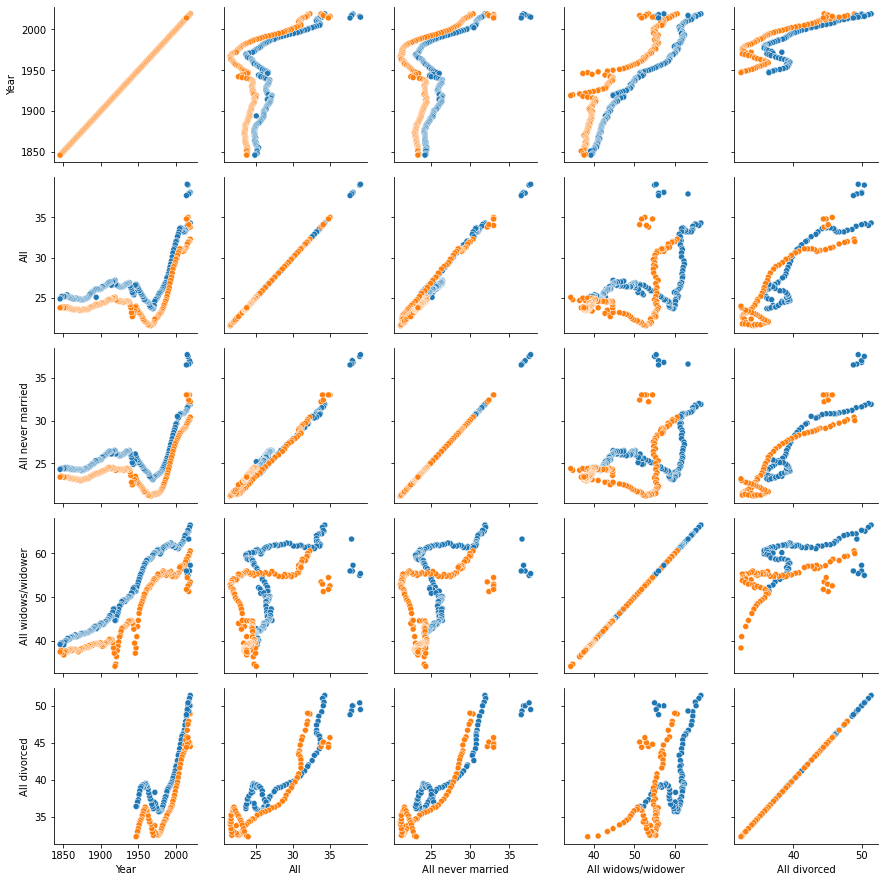

In [26]:
# looking at how legals status affects marriage
plot = sns.PairGrid(med_age, hue ="sex")
plot.map(sns.scatterplot)

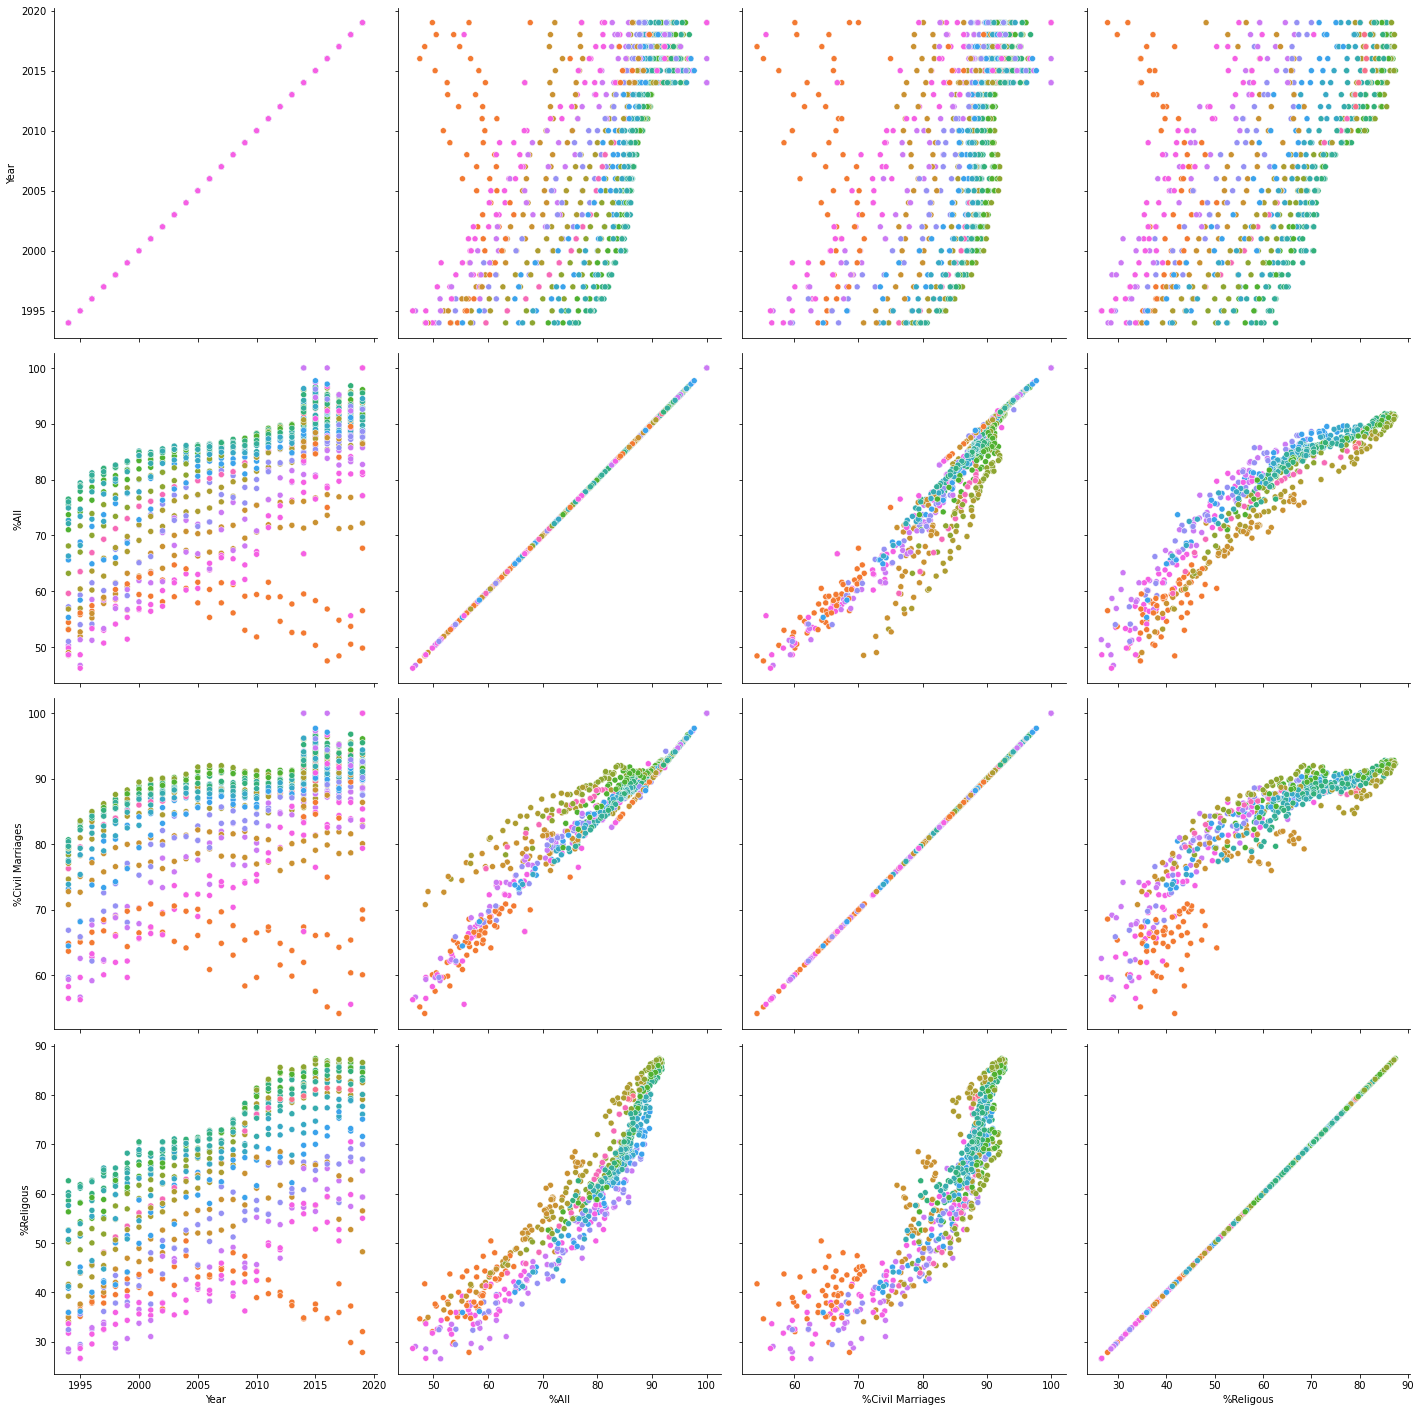

In [27]:
#looks at ceremony type and cohabitation before hand to seeany trends
plot = sns.PairGrid(co_df, hue ="Age", height = 5)
plot.map(sns.scatterplot)


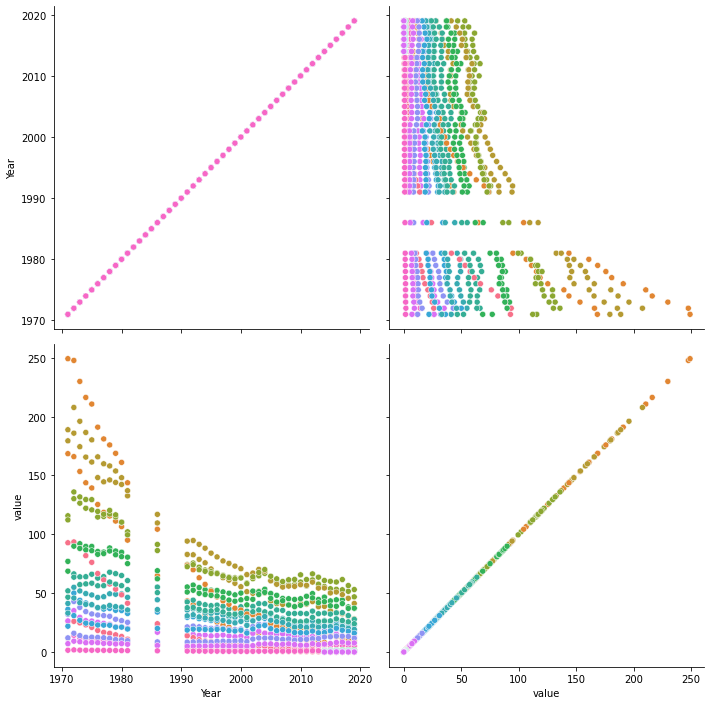

In [28]:
plot = sns.PairGrid(sex_prop, hue ="Age", height = 5)
plot.map(sns.scatterplot)

In [29]:
#under_twenty = sex_status[sex_status["Age"]=="Under 20"]
#twenty_to_four = sex_status[sex_status["Age"]=="20 to 24"]
#four_to_nine = sex_status[sex_status["Age"]=="24 to 29"]

In [30]:
#all_data = []
#ages = ["Under 20", "20 to 24", "25 to 29"]
#legal_status = ["Never married",  "Widowed", "Divorced"]
#for age in ages:
#    
#    age_data = []
#    age_df = sex_status[sex_status["Age"]==age]
#    
#    for leg in legal_status:
#
#        leg_df = age_df.loc[age_df["Legal partnership status"]==leg, ["Year", "value"]].reset_index(drop=True).dropna()
#        leg_df["value"] = leg_df["value"].astype('int')
#        age_data.append(leg_df.groupby("Year").sum())
#        
#    all_data.append(age_data)

In [31]:
#low_age_data = [[[t[0] for t in j.loc[1915:1935].values]  for j in i ]for i in all_data]
#med_age_data = [[[t[0] for t in j.loc[1957:1977].values] for j in i] for i in all_data]
#high_age_data = [[[t[0] for t in j.loc[2000:2020].values] for j in i] for i in all_data]

#low_age_data = [[low_age_data[j][i] for j in range(len(low_age_data))] for i in range(len(low_age_data))]
#med_age_data = [[med_age_data[j][i] for j in range(len(med_age_data))] for i in range(len(med_age_data))]
#high_age_data = [[high_age_data[j][i] for j in range(len(high_age_data))] for i in range(len(high_age_data))]

#boxplot_data = [low_age_data, med_age_data, high_age_data]

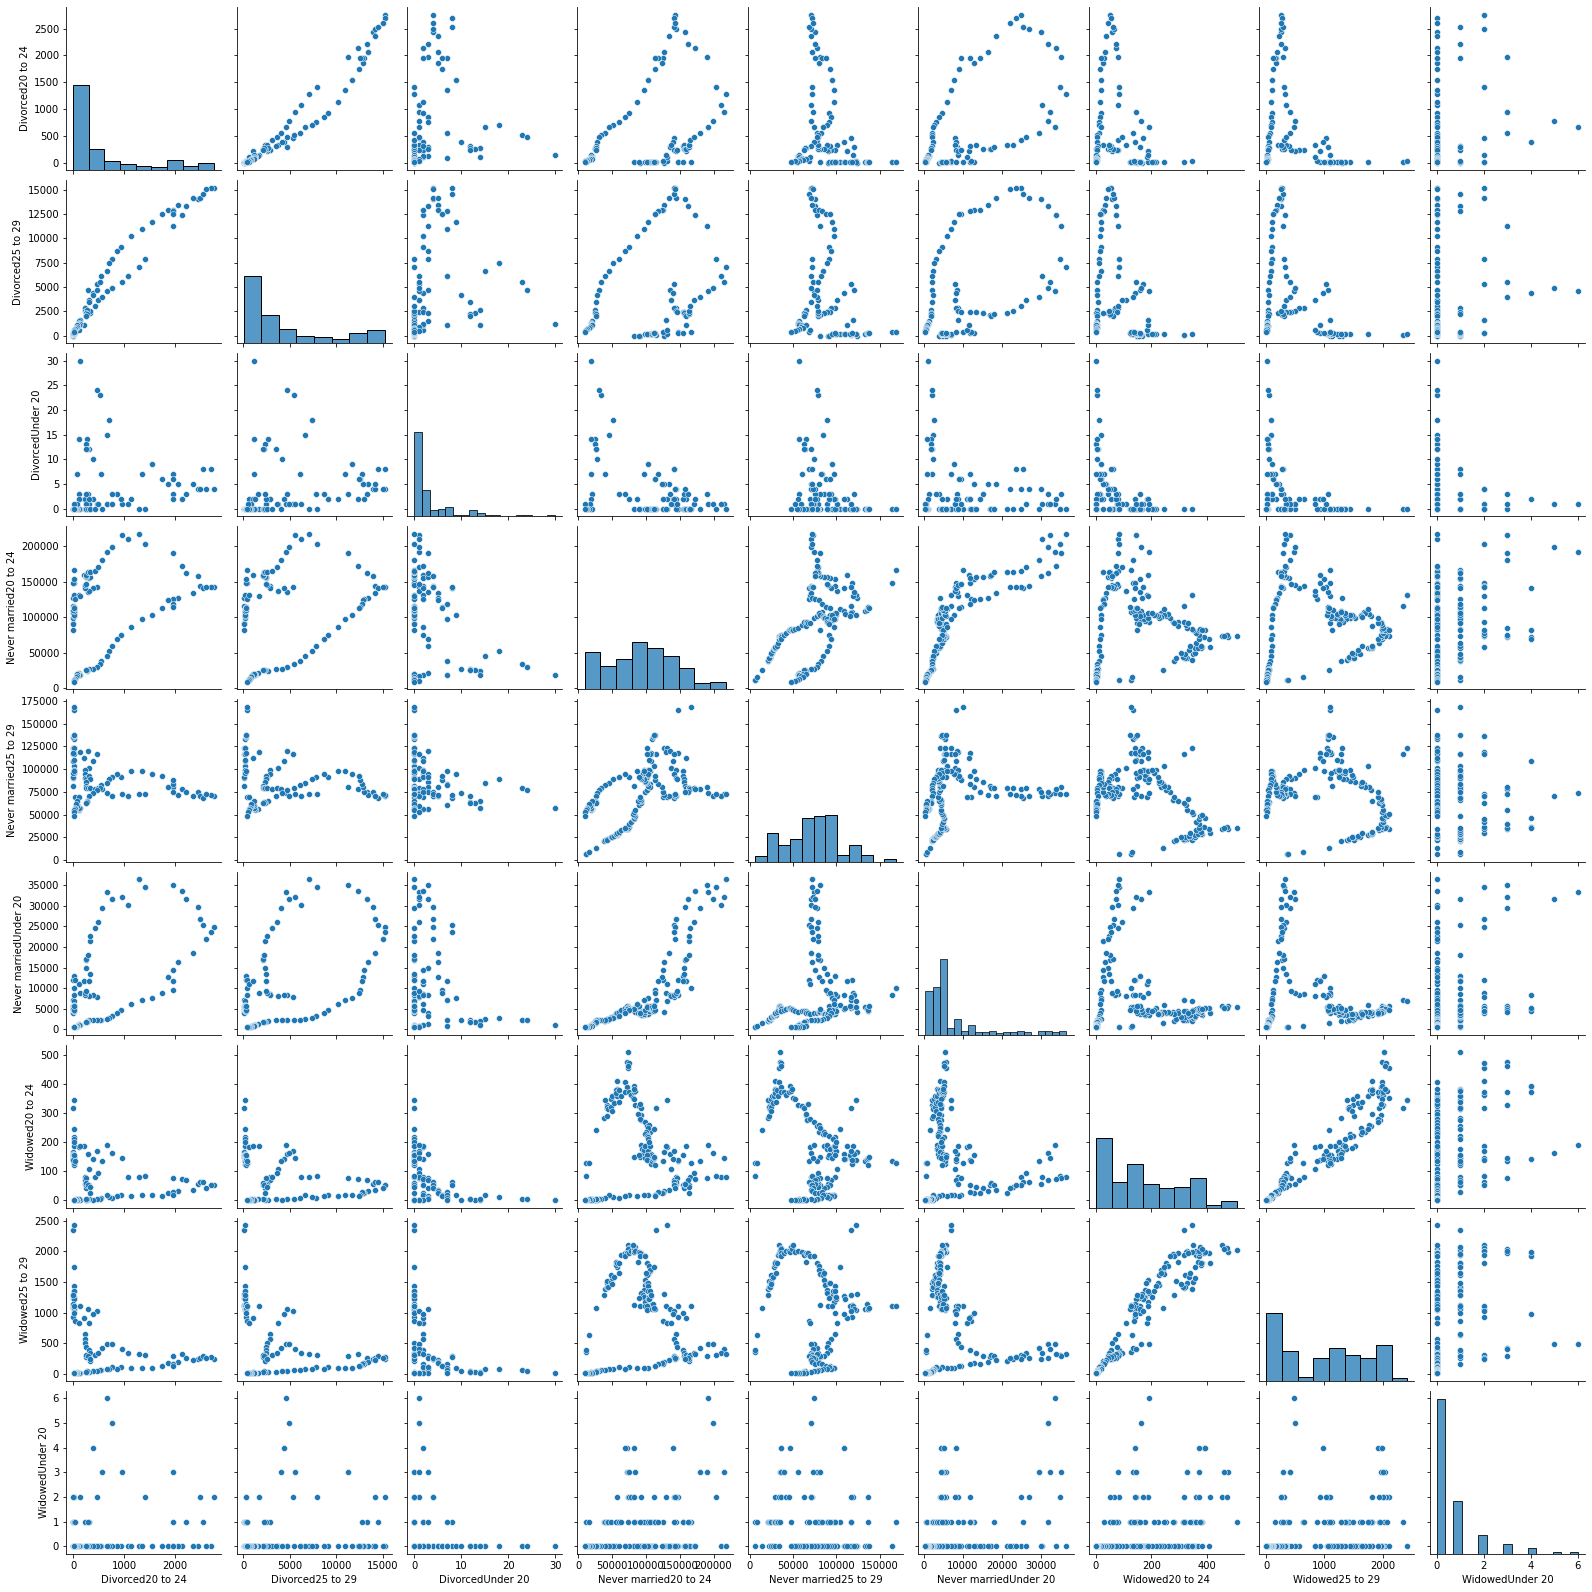

In [32]:
# this look at young ages and legal relationship satatus before marriage
#plot = sns.pairplot(sex_status,height = 5)
sex_status_young = sex_status.loc[[i in ["Under 20", "20 to 24", "25 to 29"] for i in list(sex_status["Age"])]]
sexx = sex_status_young[sex_status_young["marriage sex"]=="opposite"]
sexx = sexx[sexx["Sex"]=="Men"]

sexx["LegalAge"] = sexx["Legal partnership status"]+sexx["Age"]
#sexx =sexx[sexx["Legal partnership status"]=="Never married"]
#sns.pairplot(pd.pivot(sexx, columns = [ "Age", "Legal partnership status"], values="value", index="Year"))
test = pd.pivot(sexx, columns = ["LegalAge"], values="value", index="Year")
sns.pairplot(test)

In [33]:
#sets the data to add a rank for each age for the same sex marriages

sex_age_df = sex_age[sex_age["marriage sex"]=="same"]
sex_age_df.loc[:,"value"] = sex_age_df.loc[:,"value"].astype("int")
sex_age_df = sex_age_df.groupby(["Year", "Age"], as_index = False).sum()


rank = []
for i,j in sex_age_df.groupby("Year"):
    arg_order = np.argsort(j["value"]).reset_index(drop=True)
    fresh=np.zeros(len(sex_age_df["Age"].unique()))
    for t in range(len(arg_order)):
        fresh[arg_order[t]]= int(len(sex_age_df["Age"].unique())-t)
    rank+=list(fresh)
sex_age_df["rank"] = rank
sex_age_df

c:\users\tymoteusz.pietrenko\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Year          Age  value  rank
0   2014     20 to 24    692   7.0
1   2014     25 to 29   1751   2.0
2   2014     30 to 34   2012   1.0
3   2014     35 to 39   1546   3.0
4   2014     40 to 44   1209   4.0
..   ...          ...    ...   ...
61  2019     50 to 54   1005   6.0
62  2019     55 to 59    590   8.0
63  2019     60 to 64    309   9.0
64  2019  65 and over    278  10.0
65  2019     Under 20     39  11.0

[66 rows x 4 columns]

C:\Users\TYMOTE~1.PIE\AppData\Local\Temp/ipykernel_31104/1365820632.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  yax2.set_yticklabels(list(sex_age_df["Age"].unique()))


[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Rank'),
 Text(0.5, 1.0, 'Life Expectancy Bump Chart')]

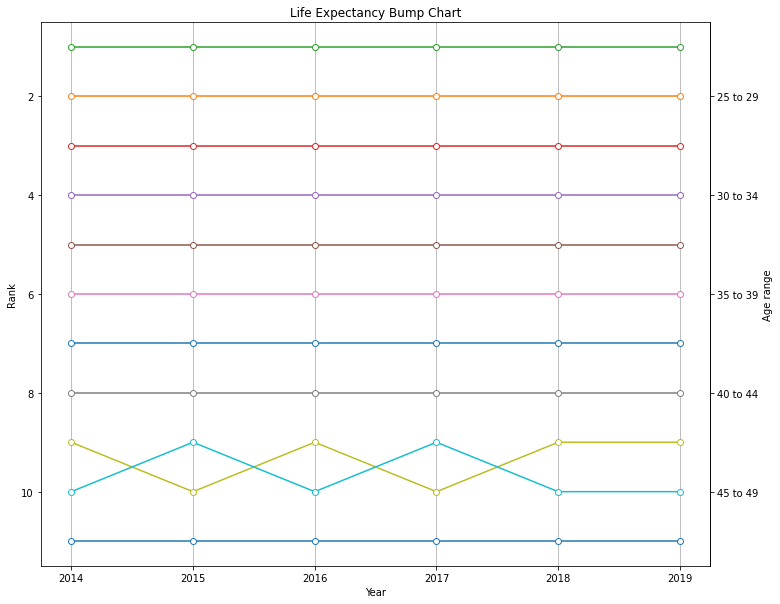

In [34]:
#draws a bump chart as a potential graph for finding trends
fig, ax = plt.subplots(figsize= (12,10))

yax2 = ax.secondary_yaxis("right")
yax2.set_yticklabels(list(sex_age_df["Age"].unique()))
yax2.set_ylabel("Age range")

for i,j in sex_age_df.groupby("Age"):
    ax.plot(j["Year"], j["rank"], "o-", mfc = "w")
    
ax.invert_yaxis()
ax.grid(axis="x")
ax.set(xlabel="Year", ylabel="Rank", title="Life Expectancy Bump Chart")


Text(0.5, 1.0, 'Proportions of women that get married at an exact Age')

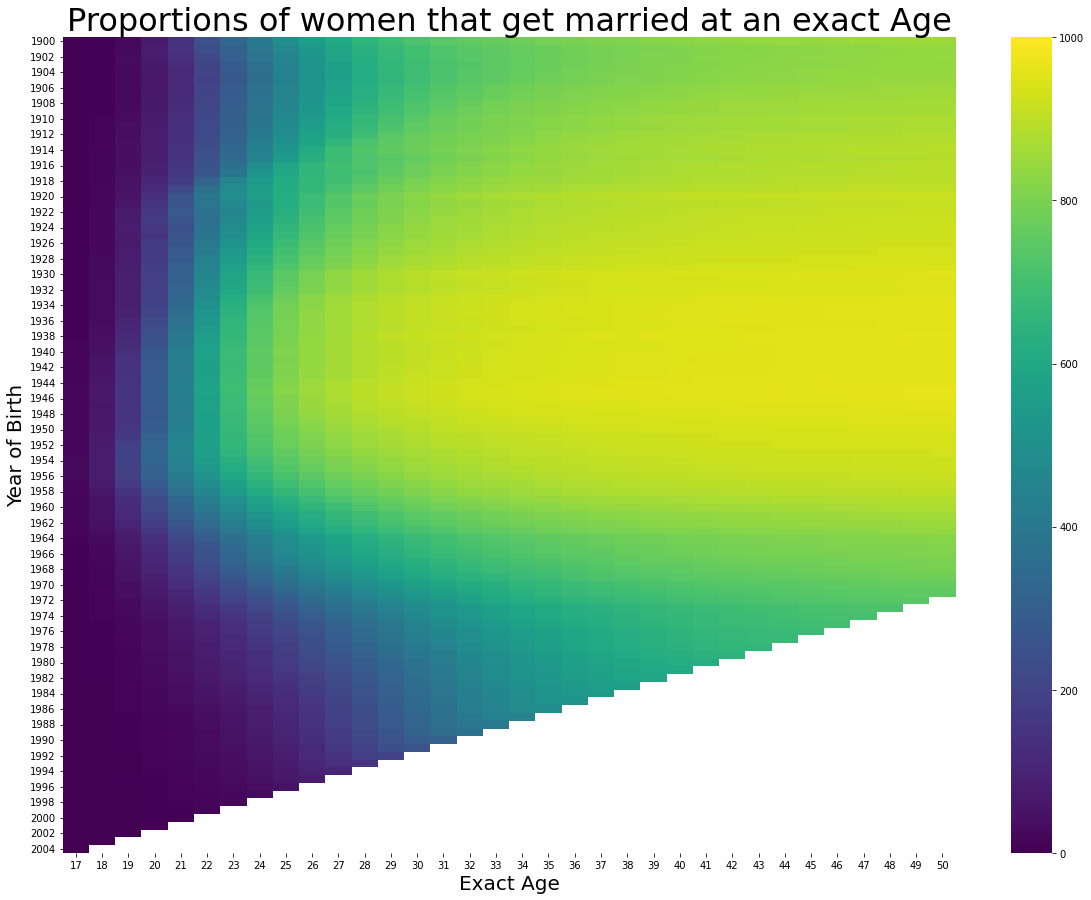

In [35]:
#creates a heat map as way to find trends
women_df = women_age.drop(["Year of birth"], axis =1)
women_df.index = women_age["Year of birth"]
women_df.columns = [i.split(" ")[2] for i in women_df.columns]

plt.figure(figsize=(20,15))
sns.heatmap(women_df, vmin=0, vmax=1000, cmap= "viridis")
plt.xlabel("Exact Age", fontsize = 20)
plt.ylabel("Year of Birth", fontsize = 20)
plt.title("Proportions of women that get married at an exact Age", fontsize =32)

# Analysis
Now from looking through the data we have chosen data and the vidualisations we want to analyse and create hypothesis test from this

## Using a stacked area chart to see the trend of marriage change over time when it comes to age

<Figure size 1800x1440 with 0 Axes>

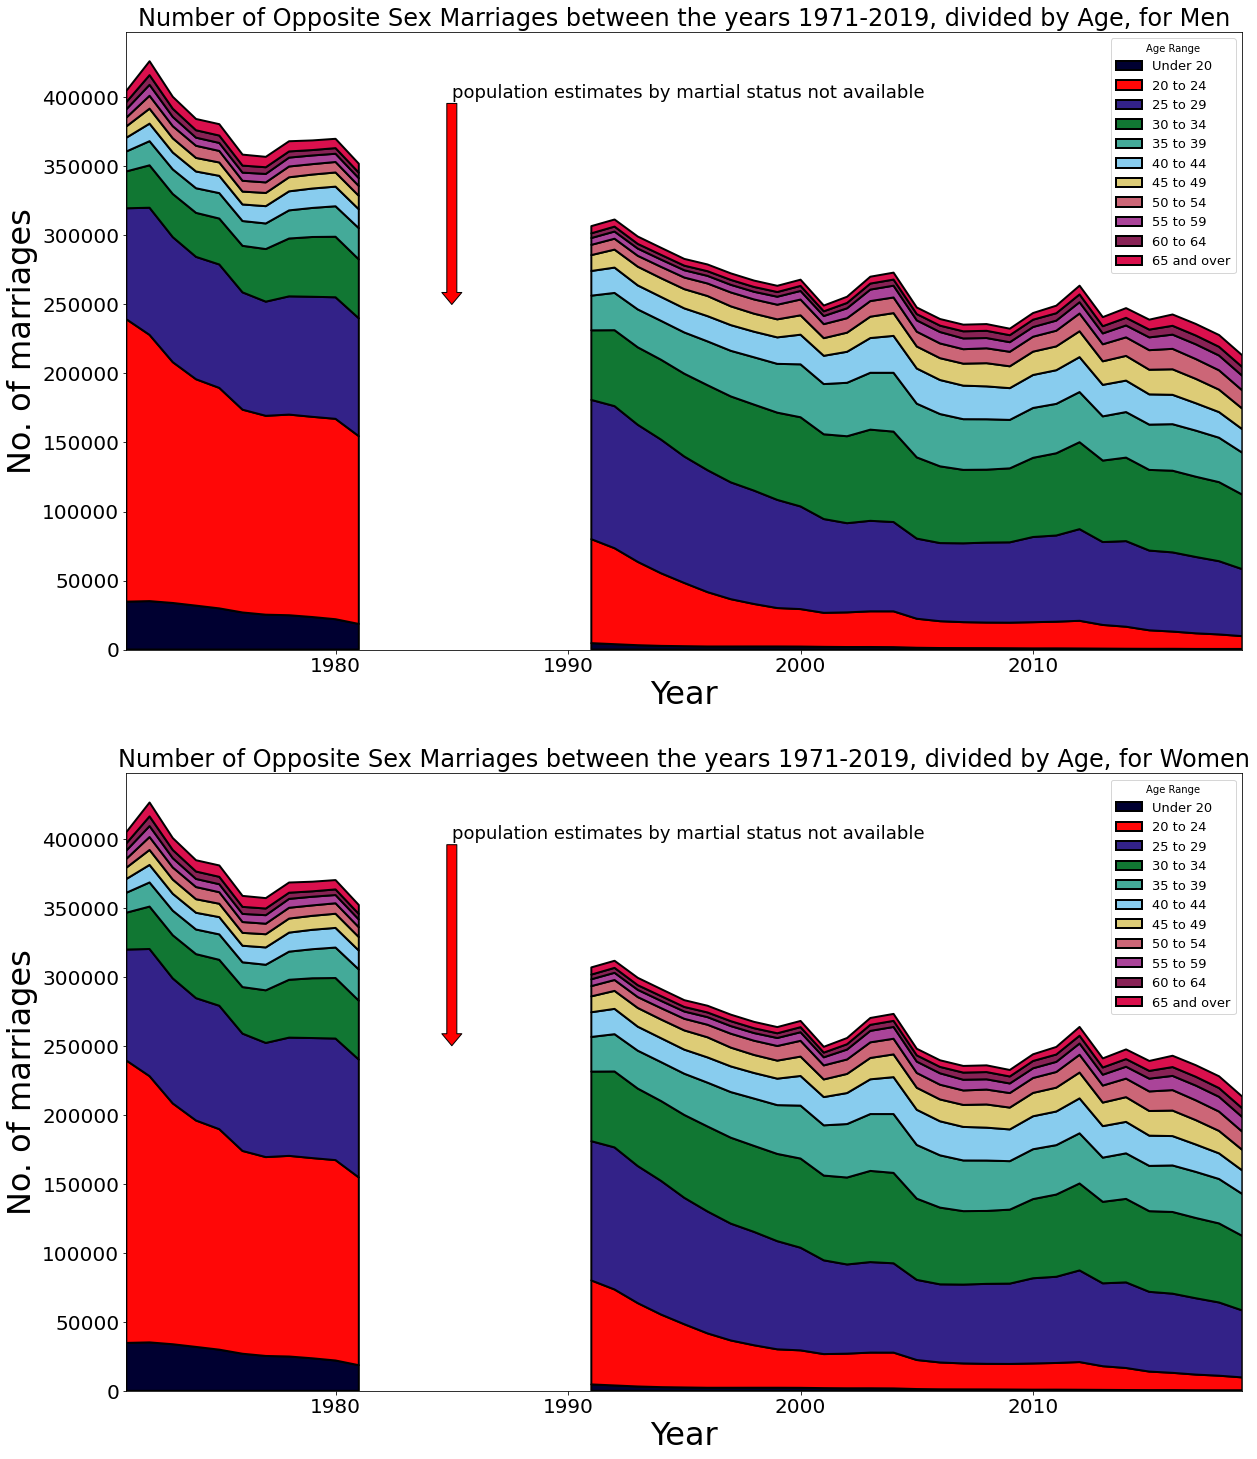

In [36]:
#selects the data for opposite sex marriages
sex_prop_df = sex_age[sex_age["marriage sex"]=="opposite"]

#removes the data in 1986 as it is not relevant  for the visualisaion
sex_prop_df = sex_prop_df[sex_prop_df["Year"]!=1986]

#splits the data into men and women
sex_prop_men  = sex_prop_df[sex_prop_df["Sex"]=="Men"]
sex_prop_women  = sex_prop_df[sex_prop_df["Sex"]=="Women"]

#gets the x value and the y value for men and women
x = list(sex_prop_men["Year"].unique())
y_women = pd.pivot(sex_prop_women, columns = "Age", values="value", index="Year").loc[list(sex_prop_df["Year"].unique()),list(sex_prop_df["Age"].unique())]
y_men = pd.pivot(sex_prop_men, columns = "Age", values="value", index="Year").loc[list(sex_prop_df["Year"].unique()),list(sex_prop_df["Age"].unique())]

#chooses a color map uitable for color blindness
color_map = ["#000031", "#FF0707","#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255", "#DA104D"]

#starts a figure with 2 subplots
plt.figure(figsize=(25,20))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = [20,25])

#creates the plot for men
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[0].stackplot(x, np.transpose(y_men.values.tolist()), labels= y_men.columns, colors= color_map, edgecolor='black', linewidth =2) 
axes[0].set_xlim(1971,2019)
axes[0].set_title("Number of Opposite Sex Marriages between the years 1971-2019, divided by Age, for Men", fontsize=24)
axes[0].set_xlabel("Year", fontsize=32)
axes[0].set_ylabel("No. of marriages", fontsize=32)
axes[0].annotate("population estimates by martial status not available", 
             xy=(1985,250000), 
             xytext=(1985, 400000), arrowprops=dict(facecolor='red', width=10, headwidth=20), fontsize=18.)
axes[0].legend(fontsize = 13, title="Age Range")


#cretes the plot for women
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[1].stackplot(x, np.transpose(y_men.values.tolist()), labels= y_men.columns, colors= color_map, edgecolor='black', linewidth =2) 
axes[1].set_xlim(1971,2019)
axes[1].set_title("Number of Opposite Sex Marriages between the years 1971-2019, divided by Age, for Women", fontsize=24)
axes[1].set_xlabel("Year", fontsize=32)
axes[1].set_ylabel("No. of marriages", fontsize=32)
axes[1].annotate("population estimates by martial status not available", 
             xy=(1985,250000), 
             xytext=(1985, 400000), arrowprops=dict(facecolor='red', width=10, headwidth=20), fontsize=18.)
axes[1].legend(fontsize = 13, title="Age Range")

plt.show()

## Boxplot data for legal relationship status before marriages for young people

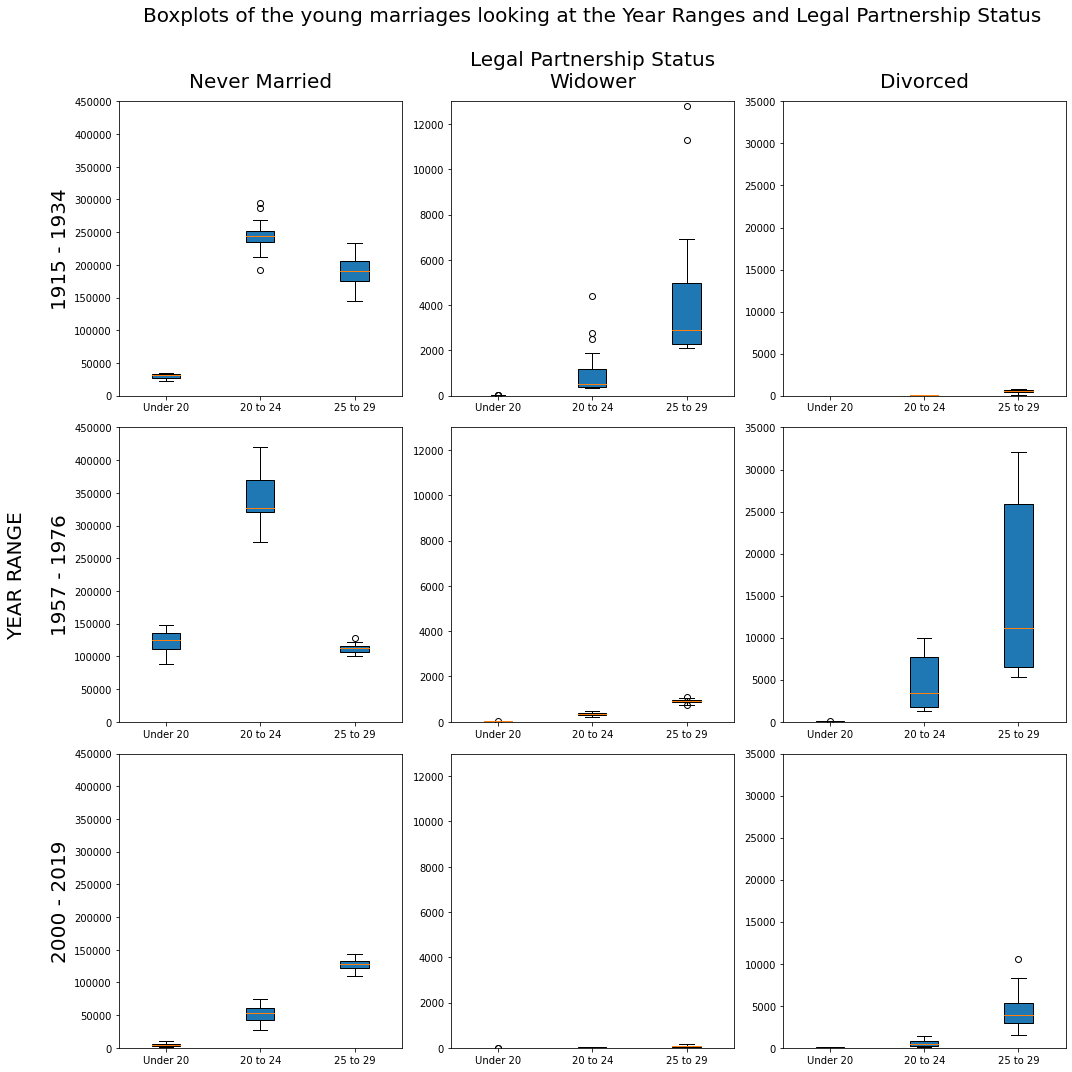

In [37]:
#gets the data for certain ages
under_twenty = sex_status[sex_status["Age"]=="Under 20"]
twenty_to_four = sex_status[sex_status["Age"]=="20 to 24"]
four_to_nine = sex_status[sex_status["Age"]=="24 to 29"]

all_data = []
ages = ["Under 20", "20 to 24", "25 to 29"]
legal_status = ["Never married",  "Widowed", "Divorced"]

#splits the data to different legal realationship status
for age in ages:
    
    age_data = []
    age_df = sex_status[sex_status["Age"]==age]
    
    for leg in legal_status:

        leg_df = age_df.loc[age_df["Legal partnership status"]==leg, ["Year", "value"]].reset_index(drop=True).dropna()
        leg_df["value"] = leg_df["value"].astype('int')
        age_data.append(leg_df.groupby("Year").sum())
        
    all_data.append(age_data)
    
#splits the data to different age ranges
low_age_data = [[[t[0] for t in j.loc[1915:1935].values]  for j in i ]for i in all_data]
med_age_data = [[[t[0] for t in j.loc[1957:1977].values] for j in i] for i in all_data]
high_age_data = [[[t[0] for t in j.loc[2000:2020].values] for j in i] for i in all_data]

low_age_data = [[low_age_data[j][i] for j in range(len(low_age_data))] for i in range(len(low_age_data))]
med_age_data = [[med_age_data[j][i] for j in range(len(med_age_data))] for i in range(len(med_age_data))]
high_age_data = [[high_age_data[j][i] for j in range(len(high_age_data))] for i in range(len(high_age_data))]

#makes the data good to put into format for blox plot
boxplot_data = [low_age_data, med_age_data, high_age_data]

#creates a 3 by 3 plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = [15,15])
for i in range(len(boxplot_data)):
    for j in range(len(boxplot_data[i])):
        
        #plots the data
        axes[i,j].boxplot(boxplot_data[i][j], patch_artist=True)
        axes[i,j].set_xticklabels(ages)
        
        #sets a standard y limit for different legal status
        if j ==0:
            axes[i,j].set_ylim([0,450000])
        elif j==1:
            axes[i,j].set_ylim([0,13000])
        else:
            axes[i,j].set_ylim([0,35000])

#add title names
axes[0,0].set_title("Never Married", pad=14, fontsize =20)
axes[0,1].set_title("Boxplots of the young marriages looking at the Year Ranges and Legal Partnership Status\n\nLegal Partnership Status\nWidower", pad=14, fontsize =20)
axes[0,2].set_title("Divorced", pad=14, fontsize =20)

axes[0,0].set_ylabel("1915 - 1934", fontsize = 20)
axes[1,0].set_ylabel("YEAR RANGE\n\n1957 - 1976", fontsize = 20)
axes[2,0].set_ylabel("2000 - 2019", fontsize = 20)

            
fig.tight_layout()
plt.show()

## Bar Chart of cohabition befor marriage in 2019 for opposite sex marriages split into ceremony type

Text(0.5, 1.0, 'cohabitation before Marriage in 2015-2019 for opposite sex marriages')

<Figure size 2160x2160 with 0 Axes>

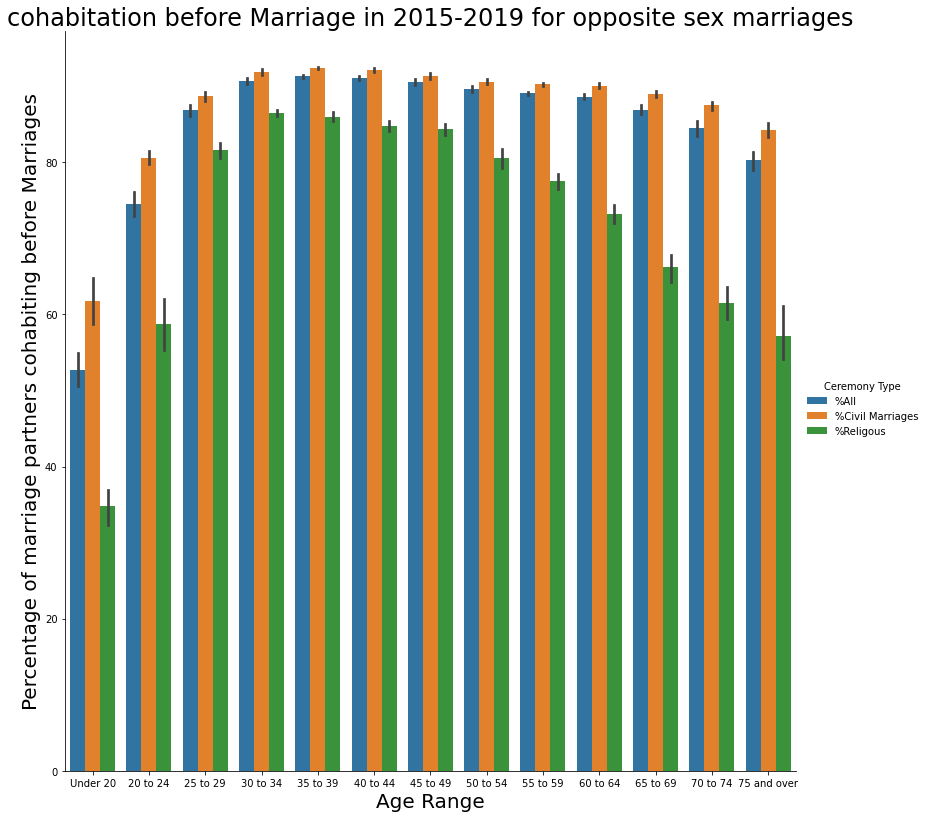

In [38]:
#changes the columns of ceremony type to a single column like a long format
co_co_df = pd.melt(co_df, id_vars=["Year","Age", "marriage sex", "sex"], ).reset_index(drop=True)

plt.figure(figsize=(30,30))

#filters the data for 2019 opposite ages and removes all ages
co_co_df = co_co_df[co_co_df["Year"].isin([2015,2016,2017, 2018,2019])].reset_index(drop=True)
co_co_df = co_co_df[co_co_df["Age"]!="All ages      "]
co_co_df = co_co_df[co_co_df["marriage sex"]=="opposite"]
co_co_df = co_co_df.rename({"variable":"Ceremony Type"}, axis=1)

#creates theplot
sns.catplot(data =co_co_df, x="Age", y = "value", kind = "bar", hue ="Ceremony Type", height =11)
plt.ylabel("Percentage of marriage partners cohabiting before Marriages", fontsize =20)
plt.xlabel("Age Range", fontsize =20)
plt.title("cohabitation before Marriage in 2015-2019 for opposite sex marriages", fontsize =24)
#plt.legend(title = "Ceremony Type")

## Dummbell Plot of same sex marriages  between the years 2014 and 2019  differing between mean and women

In [39]:
#gets the data for same sex marriages on 2014 and 2019
sex_age_df = sex_age[sex_age["marriage sex"]=="same"]
sex_age_df = sex_age_df.loc[sex_age_df["Year"].isin([2014,2019]),:]

#combines the year and  Ages
sex_age_df["ageyear"] = sex_age_df["Year"].astype("str")+": Ages "+ sex_age_df["Age"]

#creates the data for Men & Women and a line conneting for it
data = {"line_x": [], "line_y": [], "Men": [], "Women": [], "year & age": []}
for ay in list(sex_age_df["ageyear"].unique()):
    data["Men"].extend([sex_age_df.loc[(sex_age_df["Sex"]=="Men")&(sex_age_df["ageyear"]==ay)]["value"].values[0]])
    data["Women"].extend([sex_age_df.loc[(sex_age_df["Sex"]=="Women")&(sex_age_df["ageyear"]==ay)]["value"].values[0]])
    data["line_x"].extend([
        sex_age_df.loc[(sex_age_df["Sex"]=="Men")&(sex_age_df["ageyear"]==ay)]["value"].values[0],
        sex_age_df.loc[(sex_age_df["Sex"]=="Women")&(sex_age_df["ageyear"]==ay)]["value"].values[0],
        None
    ])
    data["line_y"].extend([ay, ay, None])

#plots the data 
fig = go.Figure(
    data = [
        go.Scatter(x = data["line_x"], y =data["line_y"], mode = "lines", showlegend=False,marker =dict(color = "grey")),
        go.Scatter(x = data["Men"], y =list(sex_age_df["ageyear"].unique()), mode = "markers",name="Men", marker =dict(color = "green", size =10)),
        go.Scatter(x = data["Women"], y =list(sex_age_df["ageyear"].unique()), mode = "markers",name="Women", marker =dict(color = "blue", size =10))
    ])

#adds titles to the data
fig.update_layout(height = 1000,title = "Dumbbell plot of same-sex Marriages between the years 2014 and 2019",
                  xaxis_title="Number of Marriages",
                  yaxis_title="Year and Age Range",
                 legend_title = "Sex")
fig.show()

# Hypothesis Testing
In this section we go through the hypothesis testing based on the hypothesis found through the visualisations

In [40]:
#gets the men data for year and value
sex_prop_men = sex_prop_men.dropna()
sex_prop_men["Year"] = sex_prop_men["Year"].astype("int")
sex_prop_men["value"] = sex_prop_men["value"].astype("int")

#gets the women data for year and value
sex_prop_women = sex_prop_women.dropna()
sex_prop_women["Year"] = sex_prop_women["Year"].astype("int")
sex_prop_women["value"] = sex_prop_women["value"].astype("int")

#gets the data for under 24 year olds  and over 29 year olds for men
sex_prop_young = sex_prop_men[sex_prop_men["Age"].isin(["Under 20", "20 to 24"])]
sex_prop_old = sex_prop_men[~sex_prop_men["Age"].isin(["Under 20", "20 to 24", "25 to 29"])]

#fits the data for men using simple linear regression
model_men_young=sm.ols('value ~ Year', sex_prop_young).fit()
model_men_old=sm.ols('value ~ Year', sex_prop_old).fit()

#gets the data for under 24 year olds  and over 29 year olds for men
sex_prop_young_wo = sex_prop_women[sex_prop_women["Age"].isin(["Under 20", "20 to 24"])]
sex_prop_old_wo = sex_prop_women[~sex_prop_women["Age"].isin(["Under 20", "20 to 24", "25 to 29"])]

#fits the data for men using simple linear regression
model_men_young_wo=sm.ols('value ~ Year', sex_prop_young_wo).fit()
model_men_old_wo=sm.ols('value ~ Year', sex_prop_old_wo).fit()

In [41]:
#shows the coefficient and the pvalue of the coeffiicent being significant
model_men_young.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     61.17
Date:                Wed, 31 May 2023   Prob (F-statistic):           2.09e-11
Time:                        04:50:36   Log-Likelihood:                -959.63
No. Observations:                  80   AIC:                             1923.
Df Residuals:                      78   BIC:                             1928.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.698e+06   5.96e+05      7.882      0.000    3.51e+06    5.88e+06
Year       -2334.3414    298.461     -7.821      0.000   -2928.533   -1740.150
==============================================================================
Omnibus:                        3.890   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.473
Skew:                           0.510   Prob(JB):                        0.176
Kurtosis:                       3.058   Cond. No.                     2.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
#shows the coefficient and the pvalue of the coeffiicent being significant
model_men_old.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     12.34
Date:                Wed, 31 May 2023   Prob (F-statistic):           0.000508
Time:                        04:50:36   Log-Likelihood:                -3548.7
No. Observations:                 320   AIC:                             7101.
Df Residuals:                     318   BIC:                             7109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.012e+05   1.19e+05     -3.362      0.001   -6.36e+05   -1.66e+05
Year         209.8865     59.749      3.513      0.001      92.332     327.441
==============================================================================
Omnibus:                       76.578   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.279
Skew:                           1.429   Prob(JB):                     2.30e-28
Kurtosis:                       4.175   Cond. No.                     2.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
#shows the coefficient and the pvalue of the coeffiicent being significant
model_men_young_wo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     174.3
Date:                Wed, 31 May 2023   Prob (F-statistic):           1.41e-21
Time:                        04:50:36   Log-Likelihood:                -935.66
No. Observations:                  80   AIC:                             1875.
Df Residuals:                      78   BIC:                             1880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.884e+06   4.42e+05     13.322      0.000       5e+06    6.76e+06
Year       -2920.0854    221.180    -13.202      0.000   -3360.420   -2479.750
==============================================================================
Omnibus:                        9.084   Durbin-Watson:                   0.058
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                3.190
Skew:                          -0.071   Prob(JB):                        0.203
Kurtosis:                       2.032   Cond. No.                     2.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
#shows the coefficient and the pvalue of the coeffiicent being significant
model_men_old_wo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     16.33
Date:                Wed, 31 May 2023   Prob (F-statistic):           6.68e-05
Time:                        04:50:36   Log-Likelihood:                -3503.6
No. Observations:                 320   AIC:                             7011.
Df Residuals:                     318   BIC:                             7019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.045e+05   1.04e+05     -3.902      0.000   -6.08e+05   -2.01e+05
Year         209.7188     51.899      4.041      0.000     107.610     311.827
==============================================================================
Omnibus:                       82.506   Durbin-Watson:                   0.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.157
Skew:                           1.468   Prob(JB):                     3.02e-32
Kurtosis:                       4.504   Cond. No.                     2.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
#gets the widow data from the boxplots
widow_data_young = []
for i in range(len(boxplot_data)):
    widow_data_young.append([t for j in boxplot_data[i][1] for t in j ])

#gets the divorce data from the box plots
div_data_young = []
for i in range(len(boxplot_data)):
    div_data_young.append([t for j in boxplot_data[i][2] for t in j ])

In [46]:
#uses the bartlett test to see if the data has the same variation to either use ANOVA or Kruskai-Wallis Test
test_statistic, p_value = stats.bartlett(widow_data_young[0], widow_data_young[1], widow_data_young[2])
p_value

5.0696123923563416e-114

In [47]:
# Conduct the Kruskal-Wallis Test
result1 = stats.kruskal(widow_data_young[0], widow_data_young[1], widow_data_young[2])
result2 = stats.kruskal(div_data_young[0], div_data_young[1], div_data_young[2])
 
# Print the result
print(result1)
print(result2)

KruskalResult(statistic=53.28133156609967, pvalue=2.6921909263613367e-12)
KruskalResult(statistic=40.69693123882626, pvalue=1.4547007618789619e-09)


In [48]:
#splits the cohabitation data and splits it into different ceremony types 
rel_dat = co_co_df.loc[co_co_df["Ceremony Type"]=="%Religous", "value"]
civ_dat = co_co_df.loc[co_co_df["Ceremony Type"]=="%Civil Marriages", "value"]

# Conduct the Kruskal-Wallis Test
cer_result = stats.kruskal(rel_dat, civ_dat)

print(cer_result)

KruskalResult(statistic=118.08398915945415, pvalue=1.661992493225933e-27)


In [49]:
# looks at all and sees the difference between young and older
all_cer_dat = co_co_df.loc[co_co_df["Ceremony Type"]=="%All",:]
yung_dat = all_cer_dat.loc[all_cer_dat["Age"].isin(["Under 20", "20 to 24", "25 to 29"]), "value"]
old_dat = all_cer_dat.loc[~all_cer_dat["Age"].isin(["Under 20", "20 to 24", "25 to 29"]), "value"]

# Conduct the Kruskal-Wallis Test
yung_result = stats.kruskal(yung_dat, old_dat)

print(yung_result)

KruskalResult(statistic=47.68478682948822, pvalue=5.0056094953865215e-12)


In [50]:
# creates a contingeuncy table for  2014vs 2019 for men and women
yung_age_df = sex_age_df[sex_age_df["Age"].isin(["Under 20", "20 to 24", "25 to 29", "30 to 34"])]
yung_2014 = yung_age_df[yung_age_df["Year"]==2014]
yung_2019 = yung_age_df[yung_age_df["Year"]==2019]

#the continguency data
conti_table=[[yung_2014.loc[yung_2014["Sex"]=="Men", "value"].sum(), yung_2019.loc[yung_2019["Sex"]=="Men", "value"].sum()],
[yung_2014.loc[yung_2014["Sex"]=="Women", "value"].sum(), yung_2019.loc[yung_2019["Sex"]=="Women", "value"].sum()]]

#creates a chi suared tes
stat, p, dof, expected = stats.chi2_contingency(conti_table)
print("Test stat is:", str(stat), "p-value : ", str(p))

Test stat is: 15.221053695355895 p-value :  9.563129758895404e-05


In [51]:
#splits the data into 2014 and 2019
sex_age_2014 = sex_age_df[sex_age_df["Year"]==2014]
sex_age_2019 = sex_age_df[sex_age_df["Year"]==2019]

#creates continguency table
conti_table=[[sex_age_2014.loc[sex_age_2014["Age"]==i, "value"].sum() for i in list(sex_age_2014["Age"].unique())],
 [sex_age_2019.loc[sex_age_2019["Age"]==i, "value"].sum() for i in list(sex_age_2019["Age"].unique())]]

#creates a chi squared test
stat, p, dof, expected = stats.chi2_contingency(conti_table)
print("Test stat is:", str(stat), "p-value : ", str(p))


Test stat is: 105.72350167994898 p-value :  3.8749299732983465e-18
